In [2]:
import numpy as np
from pickle import load

f = open("electrons_log",'rb')
data = np.load(f, encoding='latin1')
data = np.array(data, dtype=np.float32)
data = np.nan_to_num(data)

In [3]:
data.shape

(10000, 30, 30)

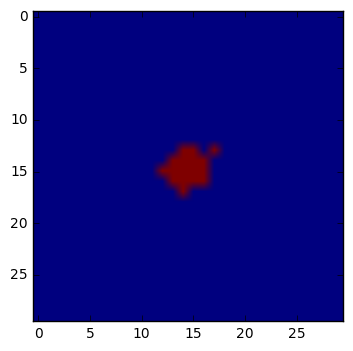

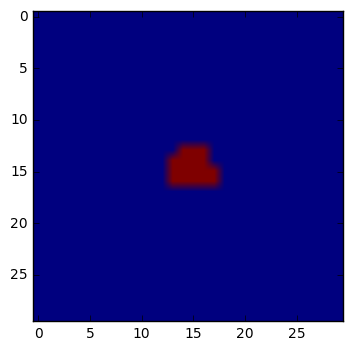

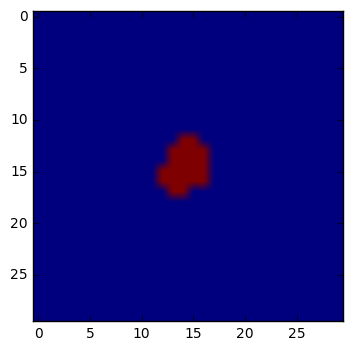

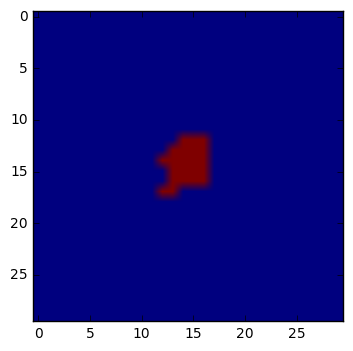

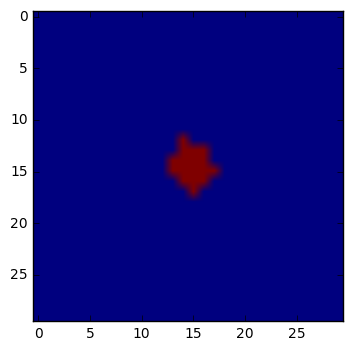

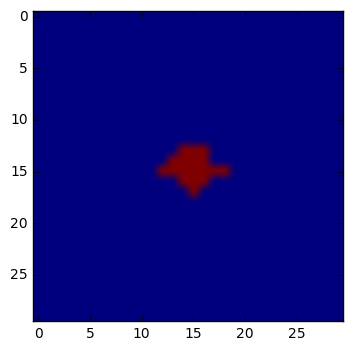

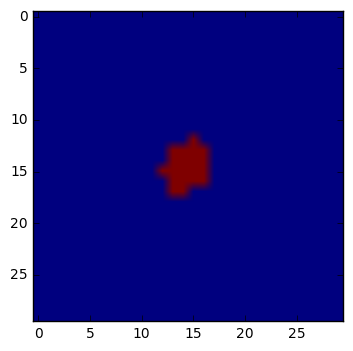

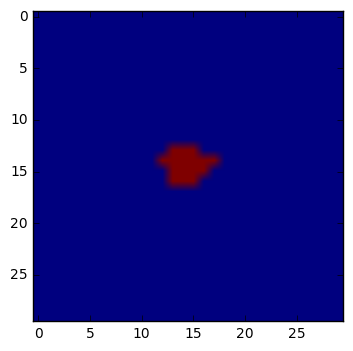

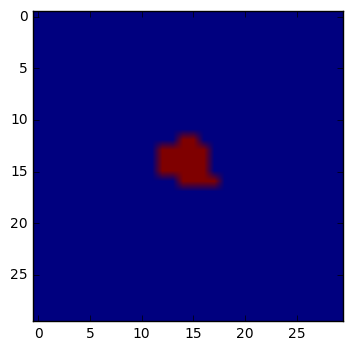

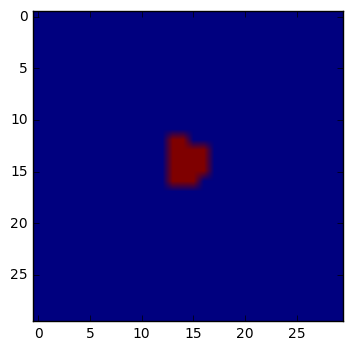

In [4]:
import scipy.misc
import matplotlib.pyplot as plt

%matplotlib inline

for i in range(10):
    plt.figure()
    plt.imshow(data[i])


/home/alex/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


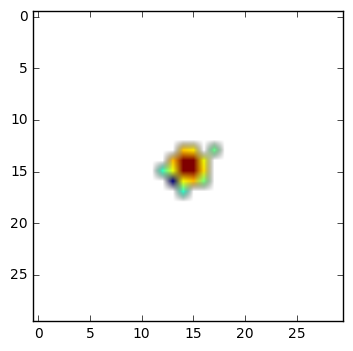

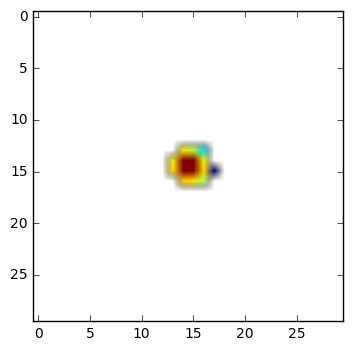

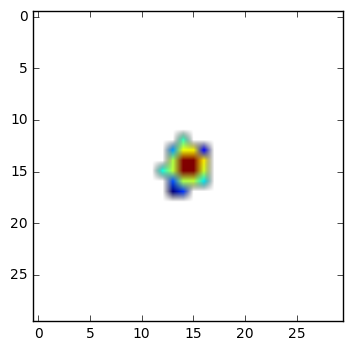

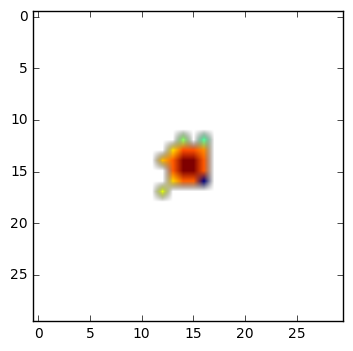

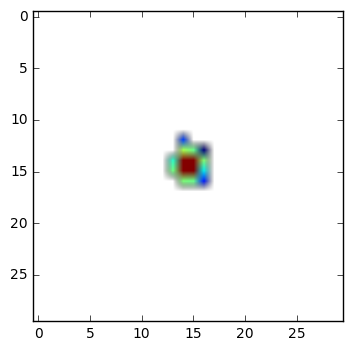

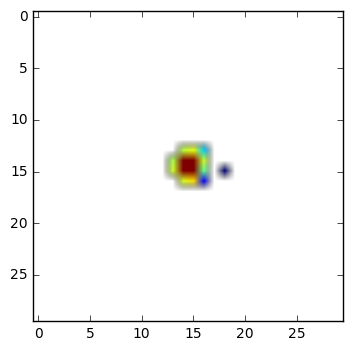

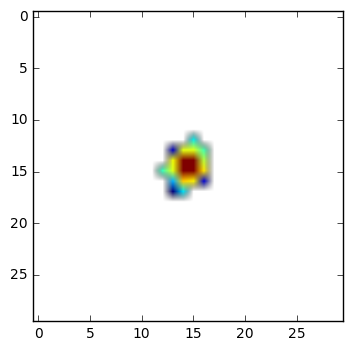

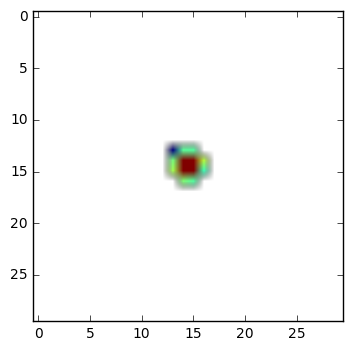

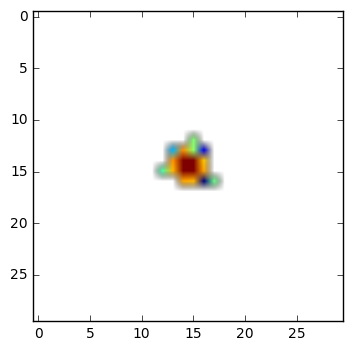

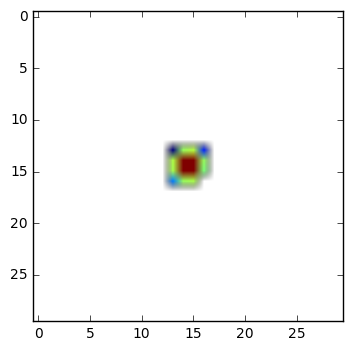

In [7]:
for i in range(10):
    plt.figure()
    plt.imshow(np.log(data[i]))

In [29]:
#разбирался с keras на mnist, так как раньше его не использовал:(
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [30]:
print("X_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [31]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print("Training matrix shape", x_train.shape)
print("Testing matrix shape", x_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [32]:
from keras.utils import np_utils

nb_classes = 10

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [33]:
#сделал простенькую сетку и посмотрел точность на тестовой выборке
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Dense(units=512, input_shape=(784,), activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train)
model.evaluate(x_test, y_test, verbose=0)[1]

Epoch 1/1
60000/60000 [==============================] - 17s 291us/step - loss: 0.1978 - acc: 0.9408


0.9647

In [34]:
#добавил сверточные и pooling слои, попытался добиться высокой точности
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=3)
model.evaluate(X_test, Y_test, verbose=0)[1]

Epoch 1/3
60000/60000 [==============================] - 276s 5ms/step - loss: 0.1087 - acc: 0.9661
Epoch 2/3
60000/60000 [==============================] - 315s 5ms/step - loss: 0.0376 - acc: 0.9887
Epoch 3/3
60000/60000 [==============================] - 304s 5ms/step - loss: 0.0241 - acc: 0.9927


0.98819999999999997

In [35]:
#добавил dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=1)
model.evaluate(X_test, Y_test, verbose=0)[1]

Epoch 1/1
60000/60000 [==============================] - 316s 5ms/step - loss: 0.1263 - acc: 0.9614


0.98170000000000002

In [42]:
# генератор
CODE_SIZE = 90

generator = Sequential()
generator.add(Conv2D(32, (3, 3), activation='relu', input_shape=(30,30,1)))
generator.add(Conv2D(64, (3, 3), activation='relu'))
generator.add(MaxPooling2D(pool_size=(2, 2)))
generator.add(Flatten())
generator.add(Dense(512, activation='relu'))
generator.add(Dense(512, activation='relu'))
generator.add(Dense(10, activation='softmax'))


(90,)
(90,)
(3, 3, 10)
(7, 7, 9)
(11, 11, 9)
(22, 22, 9)
(24, 24, 3)
(26, 26, 3)
(28, 28, 3)
(30, 30, 3)
(32, 32, 3)
(34, 34, 3)
(36, 36, 3)
(38, 38, 3)
(40, 40, 3)
(42, 42, 3)
(44, 44, 3)
(48, 48, 3)
(50, 50, 3)
(52, 52, 3)
(50, 50, 3)


In [41]:
assert generator.output_shape[1:] == data.shape[1:], "generator must output an image of shape %s, but instead it produces %s"%(data.shape[1:],generator.output_shape[1:])

AssertionError: generator must output an image of shape (30, 30), but instead it produces (60, 60, 3)

In [46]:
#дискриминатор
discriminator = Sequential()

discriminator.add(InputLayer(IMG_SHAPE))
discriminator.add(Conv2D(32,kernel_size=3,input_shape = (30,30,1),activation='relu'))
discriminator.add(Conv2D(32,kernel_size=3,activation='relu'))
discriminator.add(MaxPool2D(pool_size=(2,2)))
discriminator.add(Conv2D(64,kernel_size=3,activation='relu'))
discriminator.add(Conv2D(64,kernel_size=3,activation='relu'))
discriminator.add(MaxPool2D(pool_size=(2,2)))
discriminator.add(Conv2D(128,kernel_size=3,activation='relu'))
discriminator.add(Conv2D(128,kernel_size=3,activation='relu'))
discriminator.add(Flatten())
discriminator.add(Dense(256,activation='tanh'))
discriminator.add(Dense(2,activation=tf.nn.log_softmax))

ValueError: Input 0 is incompatible with layer conv2d_10: expected ndim=4, found ndim=3

In [ ]:
#обучение

from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(3):
        s.run(disc_optimizer,feed_dict)
        
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)